In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import pickle
import netCDF4 as nc

from scipy.interpolate import griddata
from scipy.optimize import minimize_scalar

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import moca_grid, dopioe_grid, espra, espra_Rc, gaussian_vel_reconstruction, solve_w, plot_ellipse


#### ROMS

In [2]:
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
sample_eddies = list(dic_sample.keys())

df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")


#### Data Extraction

In [3]:
def extract_eddy_domain(eddy, t, dic_sample, df_eddies,
                        mask_rho, X_grid, Y_grid,
                        k=0, radius=200,
                        uv_dir='/srv/scratch/z5297792/Climatology/u_v'):

    eddy = f'Eddy{eddy}'
    day = list(dic_sample[eddy].keys())[t]

    # pull out the snapshot DataFrame
    df_snapshot = dic_sample[eddy][day]

    # figure out which file to load
    sample_id = int(eddy[4:])
    day_num   = int(day[3:])
    row = df_eddies.loc[
        (df_eddies['ID']==sample_id)&
        (df_eddies['Day']==day_num)
    ].iloc[0]
    fname   = row['fname']
    fnumber = fname[-8:-3]

    # load and mask raw u/v
    u_raw = np.load(f'{uv_dir}/u_{fnumber}.npy')
    v_raw = np.load(f'{uv_dir}/v_{fnumber}.npy')
    u_raw = np.where(u_raw>1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(v_raw>1e30, np.nan, v_raw).astype(float)

    # find the time index
    with nc.Dataset(fname) as ds:
        ocean_time = ds.variables['ocean_time'][:].data/86400
    t_rel = np.where(ocean_time==day_num)[0][0]

    # pick out eddy parameters
    data = df_snapshot.iloc[k]
    x0, y0, Q, depth = data.x, data.y, data.Q, data.Depth
    q11, q12, q22    = Q[0,0], Q[1,0], Q[1,1]
    print(f'q11: {q11}, q12: {q12}, q22: {q22}')

    # slice out the k,t_rel snapshot and re‐mask
    u = np.where(mask_rho, u_raw[:,:,k,t_rel], np.nan)
    v = np.where(mask_rho, v_raw[:,:,k,t_rel], np.nan)

    # bounding‐box around the eddy centre
    mask_dom = np.hypot(X_grid-x0, Y_grid-y0) <= radius
    i_inds, j_inds = np.where(mask_dom)
    i_min, i_max = i_inds.min(), i_inds.max()
    j_min, j_max = j_inds.min(), j_inds.max()

    # extract the rectangular subarray
    u_eddy = u[i_min:i_max+1, j_min:j_max+1]
    v_eddy = v[i_min:i_max+1, j_min:j_max+1]
    X_eddy = X_grid[i_min:i_max+1, j_min:j_max+1]
    Y_eddy = Y_grid[i_min:i_max+1, j_min:j_max+1]
    x_eddy = X_eddy[:,0]
    y_eddy = Y_eddy[0,:]

    return {
        'u': u_eddy,
        'v': v_eddy,
        'X': X_eddy,
        'Y': Y_eddy,
        'x': x_eddy,
        'y': y_eddy,
        'q11': q11,
        'q12': q12,
        'q22': q22,
        'x0': x0,
        'y0': y0,
        'Depth': depth,
    }

def extract_transect_center(u, v, X, Y, x0, y0, r=30):
    
    # find grid point closest to the eddy centre
    dis = np.hypot(X - x0, Y - y0)
    ic, jc = np.unravel_index(np.argmin(dis), dis.shape)

    mask = dis <= r

    xi = X[mask]
    yi = Y[mask]
    ui = u[mask]
    vi = v[mask]

    return {
        'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi
    }

#### Find Rc

In [4]:
df = pd.DataFrame(columns=['Cyc'])
for eddy in sample_eddies:
    eddy = int(eddy[4:])
    cyc = df_eddies[df_eddies['ID']==eddy].iloc[0]['Cyc']
    df.loc[len(df)] = {'Cyc': cyc}
df.index = sample_eddies
df


,Cyc
Eddy2749,AE
Eddy8,AE
Eddy2504,AE
Eddy896,AE
Eddy1394,CE
Eddy382,CE
Eddy1967,CE
Eddy926,CE


In [5]:
eddy = 1967
t = 10

dic_eddy_domain = extract_eddy_domain(eddy, t, dic_sample, df_eddies, mask_rho, X_grid, Y_grid)
ue = dic_eddy_domain['u']
ve = dic_eddy_domain['v']
Xe = dic_eddy_domain['X']
Ye = dic_eddy_domain['Y']
q11e = dic_eddy_domain['q11']
q12e = dic_eddy_domain['q12']
q22e = dic_eddy_domain['q22']
x0e = dic_eddy_domain['x0']
y0e = dic_eddy_domain['y0']
Depthe = dic_eddy_domain['Depth']

dic_eddy_transect = extract_transect_center(ue, ve, Xe, Ye, x0e, y0e, r=60)
xi = dic_eddy_transect['xi']
yi = dic_eddy_transect['yi']
ui = dic_eddy_transect['ui']
vi = dic_eddy_transect['vi']

Rc, psi0 = espra_Rc(xi, yi, ui, vi, x0e, y0e, q11e, q12e, q22e)
print(Rc, psi0)


q11: -0.008418143656544594, q12: -0.000479935766615009, q22: -0.007305326419901507
6.070259162753086 35.87094477830806


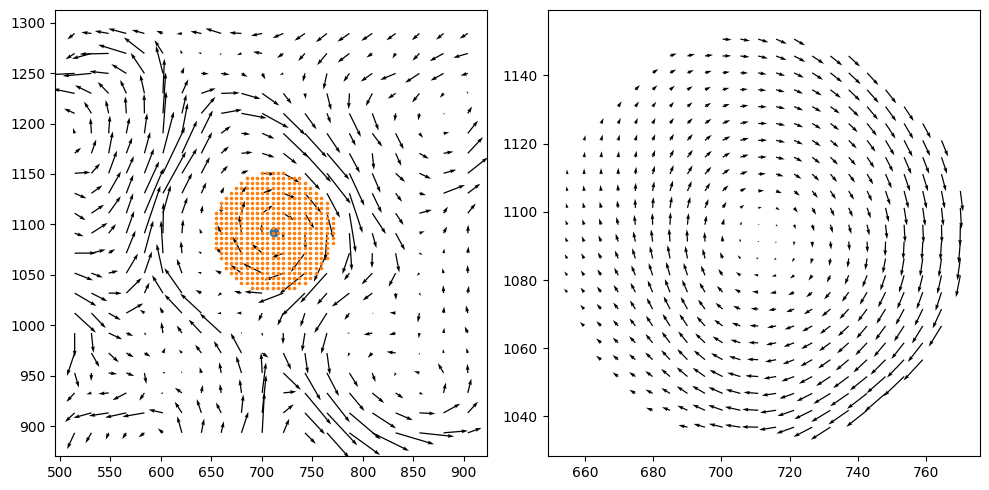

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

spacing = 4
quiv_scale = 10
axs[0].quiver(Xe[::spacing, ::spacing], Ye[::spacing, ::spacing], ue[::spacing, ::spacing], ve[::spacing, ::spacing],
             scale=quiv_scale)
axs[0].scatter(x0e, y0e)
axs[0].axis('equal')
axs[0].scatter(xi, yi, marker='.', s=10)

axs[1].quiver(xi, yi, ui, vi)
axs[1].axis('equal')

plt.tight_layout()
plt.show()

In [7]:
u_dopioe, v_dopioe, X_dopioe, Y_dopioe = gaussian_vel_reconstruction(x0e, y0e, q11e, q12e, q22e, Rc, psi0)


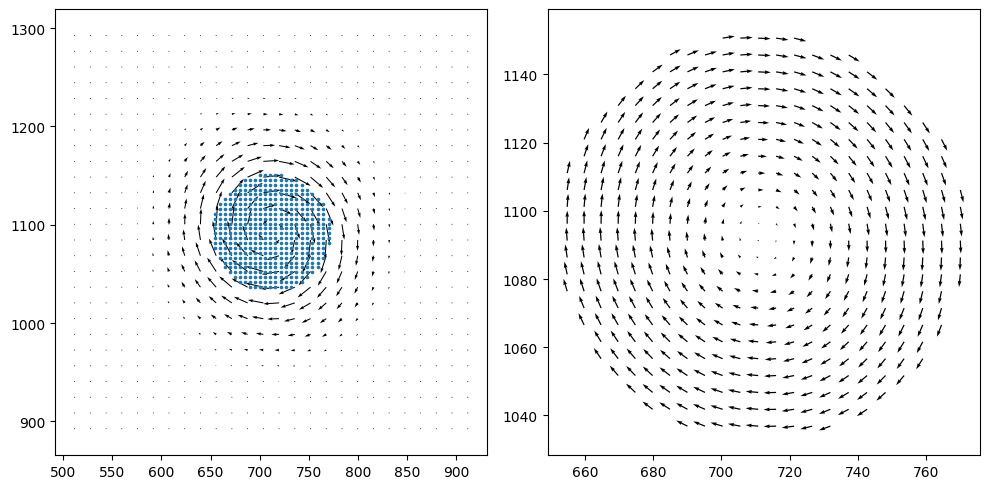

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

spacing = 2
quiv_scale = 10

axs[0].quiver(X_dopioe[::spacing, ::spacing], Y_dopioe[::spacing, ::spacing], u_dopioe[::spacing, ::spacing], v_dopioe[::spacing, ::spacing],
             scale=quiv_scale)
axs[0].scatter(xi, yi, marker='.', s=10)
axs[0].axis('equal')

points = np.column_stack((X_dopioe.ravel(), Y_dopioe.ravel()))
values_v, values_u = v_dopioe.ravel(), u_dopioe.ravel()
vi_dopioe = griddata(points, values_v, (xi, yi), method='linear')
ui_dopioe = griddata(points, values_u, (xi, yi), method='linear')

axs[1].quiver(xi, yi, ui_dopioe, vi_dopioe)
axs[1].axis('equal')

plt.tight_layout()
plt.show()

In [9]:

df_Rc = pd.DataFrame(columns=['Rc', 'psi0', 'Depth'])

dic = {}
for k in range(23):
    dic[f'z{k}'] = {}
    dic_eddy_domain = extract_eddy_domain(eddy, t, dic_sample, df_eddies, mask_rho, X_grid, Y_grid, k=k)
    ue = dic_eddy_domain['u']
    ve = dic_eddy_domain['v']
    Xe = dic_eddy_domain['X']
    Ye = dic_eddy_domain['Y']
    q11e = dic_eddy_domain['q11']
    q12e = dic_eddy_domain['q12']
    q22e = dic_eddy_domain['q22']
    x0e = dic_eddy_domain['x0']
    y0e = dic_eddy_domain['y0']
    Depthe = dic_eddy_domain['Depth']
    
    dic_eddy_transect = extract_transect_center(ue, ve, Xe, Ye, x0e, y0e, r=60)
    xi = dic_eddy_transect['xi']
    yi = dic_eddy_transect['yi']
    ui = dic_eddy_transect['ui']
    vi = dic_eddy_transect['vi']
    
    Rc_opt, psi0_opt = espra_Rc(xi, yi, ui, vi, x0e, y0e, q11e, q12e, q22e)
    df_Rc.loc[len(df_Rc)] = {'Rc': Rc_opt, 'psi0': psi0_opt, 'Depth': Depthe}

    u_dopioe, v_dopioe, X_dopioe, Y_dopioe = gaussian_vel_reconstruction(x0e, y0e, q11e, q12e, q22e, Rc_opt, psi0_opt)
    dic[f'z{k}']['u'] = u_dopioe
    dic[f'z{k}']['v'] = v_dopioe
    dic[f'z{k}']['X'] = X_dopioe
    dic[f'z{k}']['Y'] = Y_dopioe
    dic[f'z{k}']['Depth'] = z_r[k]

df_Rc


q11: -0.008418143656544594, q12: -0.000479935766615009, q22: -0.007305326419901507
q11: -0.008285623241885497, q12: -0.0003726952898278265, q22: -0.007494234853662745
q11: -0.007824457270776446, q12: -0.0006860148399992193, q22: -0.007307966478212771
q11: -0.0076171495866252294, q12: -0.0007369138588126854, q22: -0.007262103396722901
q11: -0.007367482961443314, q12: -0.0007492268312024904, q22: -0.007080434806506334
q11: -0.007066734728090202, q12: -0.0007053779768730945, q22: -0.006573175309051117
q11: -0.006972477072269749, q12: -0.0005932824260102876, q22: -0.0064099386397199285
q11: -0.007326777624852041, q12: -0.0008201017946835248, q22: -0.0064834260155066355
q11: -0.007299140044968177, q12: -0.00041007984544231657, q22: -0.006549413167757558
q11: -0.007105046948196286, q12: -0.00047474781252059104, q22: -0.006281639542087276
q11: -0.006889345947558882, q12: -0.0004911922223061392, q22: -0.00593410671775711
q11: -0.00658719844598145, q12: -0.0005368031046767028, q22: -0.005483833

,Rc,psi0,Depth
0,6.070259,35.870945,-1.783320
1,6.156933,37.483663,-5.879627
2,6.257092,39.472072,-10.725783
3,6.328378,40.755491,-16.383097
4,6.326150,41.362625,-22.925581
5,6.594563,45.269207,-30.444118
6,6.519980,44.006670,-39.052712
7,6.489613,42.462137,-48.897638
8,6.508737,42.345453,-60.170639
9,6.470995,42.169768,-73.127842


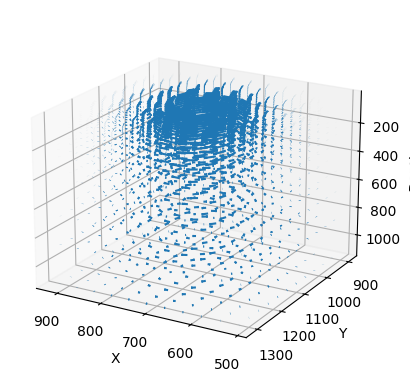

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

spacing = 5
scale_factor = 100  # adjust arrow length

for key in dic:
    d = dic[key]
    XX = d['X'][::spacing, ::spacing]
    YY = d['Y'][::spacing, ::spacing]
    ZZ = -d['Depth']
    UU = d['u'][::spacing, ::spacing] * scale_factor
    VV = d['v'][::spacing, ::spacing] * scale_factor
    WW = np.zeros_like(UU)

    ax.quiver(XX, YY, ZZ, UU, VV, WW)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')
ax.invert_zaxis()
ax.view_init(elev=20, azim=120)

plt.show()



In [12]:
import numpy as np
from scipy.interpolate import griddata

# 1) collect all (x,y,z) points and their u,v values
pts = []
uvals = []
vvals = []
for d in dic.values():
    X = d['X'].ravel()
    Y = d['Y'].ravel()
    Z = -d['Depth'] * np.ones_like(X)
    pts.append(np.column_stack((X, Y, Z)))
    uvals.append((d['u'] * scale_factor).ravel())
    vvals.append((d['v'] * scale_factor).ravel())

pts   = np.vstack(pts)
uvals = np.concatenate(uvals)
vvals = np.concatenate(vvals)

# 2) choose your new grid resolution
nz = len(dic)
ny = max(d['X'].shape[0] for d in dic.values()) // 2
nx = max(d['X'].shape[1] for d in dic.values()) // 2

xi = np.linspace(pts[:,0].min(), pts[:,0].max(), nx)
yi = np.linspace(pts[:,1].min(), pts[:,1].max(), ny)
# zi = np.linspace(pts[:,2].min(), pts[:,2].max(), nz)
zi = -z_r[:np.sort([int(a[1:]) for a in dic.keys()]).max()+1]

Xg, Yg, Zg = np.meshgrid(xi, yi, zi, indexing='xy')
grid_pts   = np.column_stack((Xg.ravel(), Yg.ravel(), Zg.ravel()))

# 3) interpolate onto the cube
U = griddata(pts, uvals, grid_pts, method='linear', fill_value=0)
V = griddata(pts, vvals, grid_pts, method='linear', fill_value=0)
# W = np.zeros_like(U)

# 4) reshape back to 3D
U = U.reshape(Xg.shape)
V = V.reshape(Xg.shape)
# W = W.reshape(Xg.shape)


In [13]:
W = solve_w(U, V, xi, yi, zi)


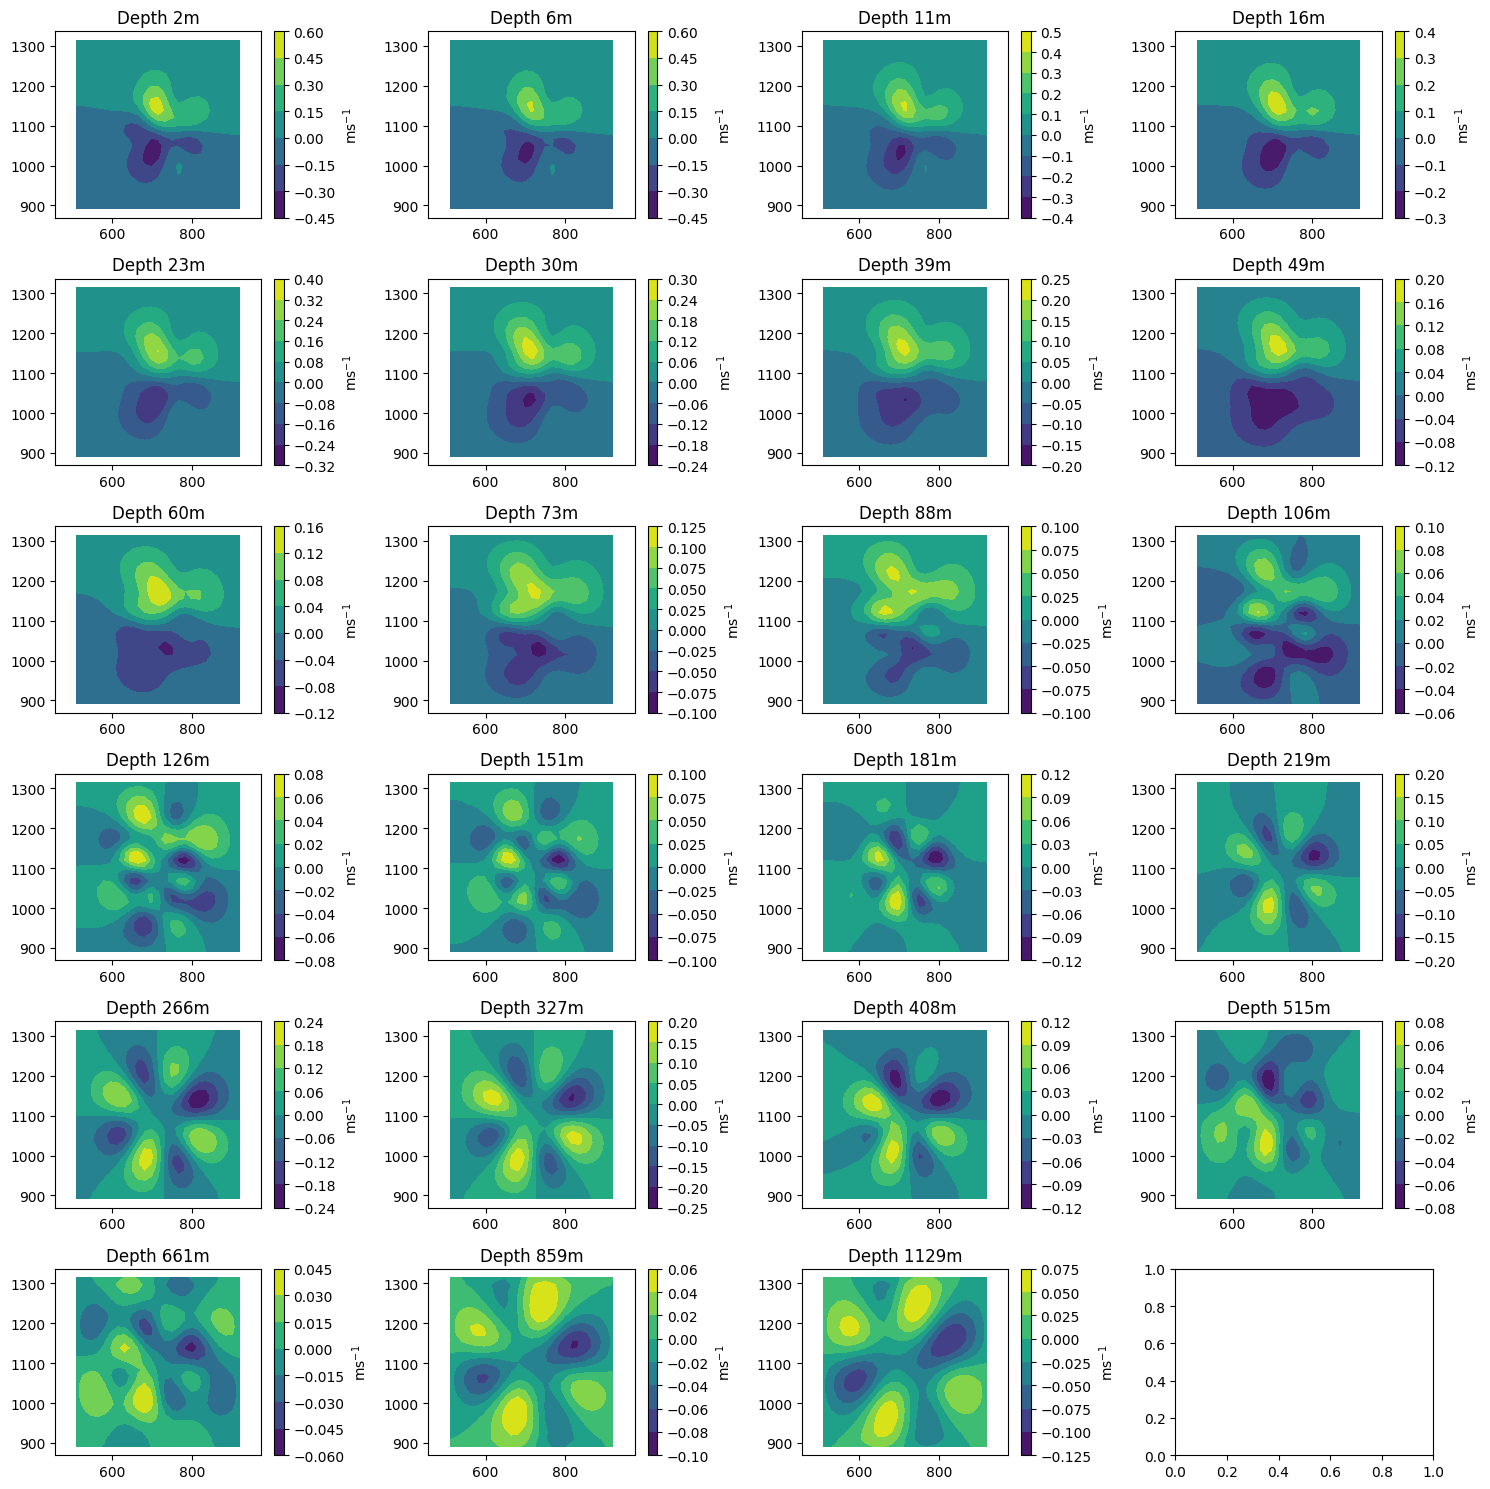

In [14]:
fig, axs = plt.subplots(6, 4, figsize=(15, 15))
for p in range(W.shape[-1]):
    ax = axs[p // 4, p % 4]
    cf = ax.contourf(xi, yi, W[:, :, p])# * 86400 )
    ax.axis('equal')
    ax.set_title(f'Depth {round(zi[p])}m')
    # fig.colorbar(cf, ax=ax, label=r'm Day$^{-1}$')
    fig.colorbar(cf, ax=ax, label=r'ms$^{-1}$')
plt.tight_layout()
plt.show()



### $\sigma_{OW}$

In [15]:
def calc_ow(uu, vv, dx, dy, flag=True):
    WIDTH, LENGTH, SIGMAS = uu.shape

    if flag:
        for k in range(SIGMAS):
            uu[:,:,k] = uu[:,:,k].T
            vv[:,:,k] = vv[:,:,k].T
    
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std


In [16]:
dx = np.diff(xi)[0]
dy = np.diff(yi)[0]

ow = calc_ow(U, V, dx*1000, dy*1000)
sigma_ow = normalize_matrix(ow)


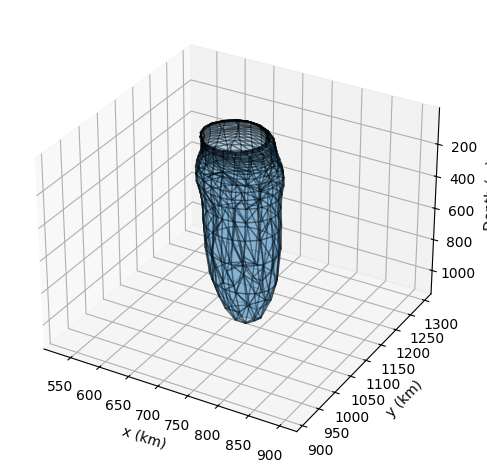

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from scipy.ndimage import map_coordinates

# ---- assume you already have ----
# sigma_ow : 3D numpy array of your scalar field
# Xg, Yg, Zg : 3D numpy arrays (same shape as sigma_ow)
# ---------------------------------

# 1. extract isosurface in index-space
verts, faces, normals, values = marching_cubes(sigma_ow, level=-0.2)

# 2. map each index‐space vertex into your real-world coords
#    verts is (Nverts, 3), columns = (i, j, k)
#    map_coordinates expects coordinates as (dim, Npoints)
pts = verts.T  # shape (3, Nverts)

# interpolate each coordinate array at those fractional indices
real_x = map_coordinates(Xg, pts, order=1)
real_y = map_coordinates(Yg, pts, order=1)
real_z = map_coordinates(Zg, pts, order=1)

# stack back into (Nverts, 3)
real_verts = np.vstack((real_x, real_y, real_z)).T

# 3. plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mesh = Poly3DCollection(real_verts[faces], alpha=0.3)
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

# # optionally plot quiver of your velocity vectors (downsampled)
# step = 5
# ax.quiver(
#     Xg[::step,::step,::step],
#     Yg[::step,::step,::step],
#     Zg[::step,::step,::step],
#     U[::step,::step,::step],  # replace Ui, Vi, Wi with your vector components
#     V[::step,::step,::step],
#     W[::step,::step,::step],
#     length=10, normalize=True,  # adjust as needed
#     linewidths=0.5
# )

# 4. set axes limits to the extents of your grid
ax.set_xlim(Xg.min(), Xg.max())
ax.set_ylim(Yg.min(), Yg.max())
ax.set_zlim(Zg.min(), Zg.max())

# if you still want z inverted:
ax.invert_zaxis()

ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (m)')

plt.tight_layout()
plt.show()

